This code is a 1D example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html that we modified.
<br>

In [1]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [2]:
# # Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
# if torch.cuda.is_available():
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
#     print("/////////////////\n Tensors type on GPU \n///////////////")
# print("/////////////////\n Tensors type on CPU \n///////////////")

In [3]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
#Geometry and residual
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
nu = 1
c = 1


In [6]:

def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=0)

    # Backend pytorch
    return (
        dy_t
        + c*dy_x
        - nu*dy_xx
        
        )

#Conditions (Boudary & Initial)
def IC_func(x):
    return -np.sin(np.pi * x[:, 0:1])

def BC_func(x):
    return 0


ic = dde.icbc.IC(geomtime, IC_func, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, BC_func, lambda _, on_boundary: on_boundary)

In [7]:
'''Analytical Solution of the advection-diffusion problem'''

def analytical_sol(x, t, N, C=c, v=nu):
    sum_sinh = 0
    sum_cosh = 0
    
    for p in range(N+1): 
        some_term = (C**4 + 8*(C*np.pi*v)**2*(p**2+1)+16*(np.pi*v)**4*(p**2-1)**2)
        term_sinh = (-1)**p*(2*p * np.sin(p*np.pi*x)) * np.exp(-v*p**2*np.pi**2*t)/some_term
        sum_sinh += term_sinh
        
        some_term = (C**4+ (C*np.pi*v)**2*(8*p**2 + 8*p + 10) + (np.pi*v)**4*(4*p**2+4*p-3)**2)
        term_cosh = (-1)**p*(2*p + 1) * np.cos((2*p+1)/2*np.pi*x)* np.exp(-v*(2*p+1)**2/4*np.pi**2*t)/some_term

        sum_cosh += term_cosh
    
    
    u_xt = 16*np.pi**2*v**3*C * np.exp(C/(2*v)*(x-C/2*t)) * (np.sinh(C/(2*v)) * sum_sinh + np.cosh(C/(2*v)) * sum_cosh)
    
    return u_xt




# def sinh_quotient_term(p, C, v):
#     return (C**4 + 8*(C*np.pi*v)**2*(p**2+1)+16*(np.pi*v)**4*(p**2-1)**2)

# def cosh_quotient_term(p, C, v):
#         return (C**4+ (C*np.pi*v)**2*(8*p**2 + 8*p + 10) + (np.pi*v)**4*(4*p**2+4*p-3)**2)

# def analytical_sol(x, t, N, C=c, v=nu):
#     sum_sinh = np.sum([(-1)**p*(2*p * np.sin(p*np.pi*x)) * np.exp(-v*p**2*np.pi**2*t) / sinh_quotient_term(p, C, v) for p in range(N+1)])
#     sum_cosh = np.sum([(-1)**p*(2*p + 1) * np.cos((2*p+1)/2*np.pi*x)* np.exp(-v*(2*p+1)**2/4*np.pi**2*t)/ cosh_quotient_term(p, C,v) for p in range(N+1)])
#     u_xt = 16*np.pi**2*v**3*C * np.exp(C/(2*v)*(x-C/2*t)) * (np.sinh(C/(2*v)) * sum_sinh + np.cosh(C/(2*v)) * sum_cosh)  
#     return u_xt

# def analytical_sol_approx(x, t,N=200):
#     S = np.sum(np.array([  (-1)**p*(2*p*np.sin(p*np.pi*x) + (2*p+1)*np.cos((2*p+1)/2*np.pi*x) ) for p in range(N+1)]  ))
#     return 8*np.pi**2*(nu/c)**3*np.exp((c/(2*nu))*(x+1 - c/2*t)) * S


# def analytical_sol_approx_2(x, t):
#     return (c*t < x+1)*-np.sin(np.pi*(x-c*t))*(1-nu*np.pi**2*(x-1))


Some **documentation for the TimePDE**: https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.pde.PDE  .
Go check the deepxde.data.pde module and then, timepde (cf link column on the site). One can e.g set a specific initialization of points (train_distribution parameter).

In [8]:
#Data and model:
data = dde.data.TimePDE(
    geometryxtime=geomtime,
    pde=pde,
    ic_bcs=[bc,ic],

    num_domain=100,
    num_boundary=20,
    num_initial=20,
    train_distribution='Hammersley', #Way of Intializing the points (on the domain, on the boundary and initial) 
    num_test=10000,
)


layer_size = [2] + [32] * 3 + [1]
# n = 10
# activation = f"LAAF-{n} relu"  # "LAAF-10 relu"
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
# dde.optimizers.set_LBFGS_options
model_print = dde.Model(data, net)

: 

In [39]:
def create_model(config):
    '''config = [nb_x_train, nb_t_train]'''
    # learning_rate, num_dense_layers, num_dense_nodes, activation = config
    nb_x_train, nb_t_train = config
    nb_x_test, nb_t_test = 100, 20
    PDE_weight, IC_weight, BC_weight = 1, 1, 1
    d=1
    learning_rate = 1e-3

    data = dde.data.TimePDE(
        geometryxtime=geomtime,
        pde=pde,
        ic_bcs=[bc,ic],
        train_distribution='Hammersley',
        
        num_initial=nb_x_train, #et pas nb_t_train
        num_domain=nb_x_train**d*nb_t_train,
        num_boundary=2*nb_t_train,
        num_test=nb_x_test*nb_t_test,
    )


    layer_size = [2] + [32] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate, loss= 'MSE', loss_weights=[PDE_weight, IC_weight, BC_weight])
    return model

In [40]:
model_opti = True
opti_hyperparametre= False

list_nb_x_train = [5, 10, 15]
list_nb_t_train = [5, 10, 15]

best_hyper_tuple = [0, 0]
best_lost_test = 1000
best_lost_epoch = 0
if opti_hyperparametre:
    for nb_x in list_nb_x_train:
        for nb_t in list_nb_t_train:
            model_hyper = create_model([nb_x, nb_t])
            early_stopping_best= dde.callbacks.ModelCheckpoint("Modeles_adv_1d/model_"+str(nb_x)+"_"+str(nb_t), verbose=1, save_better_only=True, period=5, monitor='test loss')
            early_stopping_var = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)

            losshistory, train_state = model_hyper.train(iterations=6000, callbacks=[early_stopping_best, early_stopping_var])


            array_losstest = np.sum(np.array(losshistory.loss_test), axis=1)
            loss_test = np.min(array_losstest) #"Vrai loss" sans poids
            if loss_test < best_lost_test:
                best_lost_test = loss_test
                best_hyper_tuple = [nb_x, nb_t]
                best_lost_epoch = np.array(losshistory.steps)[np.argmin(array_losstest)]
                best_losshistory = losshistory
                
    print(best_hyper_tuple)
    print(best_lost_test)
    print(best_lost_epoch)
    print(best_losshistory)

In [41]:
#Restauration of the model
already_in_memory = True


if model_opti:
    if  already_in_memory:
        best_hyper_tuple = [15, 10]
        model_print = create_model(best_hyper_tuple)
        model_print.restore("Modeles_adv_1d/Best_models_1D/model_29-04_test.pt")
    else:
        model_print = create_model(best_hyper_tuple)
        model_print.restore(
            save_path="Modeles_adv_1d/model_{nb_x}_{nb_t}-{nb_epoch}.pt".format(nb_x = best_hyper_tuple[0], nb_t = best_hyper_tuple[1], nb_epoch = best_lost_epoch))


Compiling model...
'compile' took 0.000260 s



Here is **the documentation of model.compile** : "https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#deepxde.model.Model.compile". In the loss and loss_weights parameters, one must order the weights like this : weights for the pde, weights for each element of bcs. bcs is the ic bc list in the input of data. The weights for the bcs list is ordered the same way as bcs. 


Some Git webpage for model saving issues: https://github.com/lululxvi/deepxde/issues/57

**Some Q&A:** 
https://deepxde.readthedocs.io/en/latest/user/faq.html#general-usage

One can save on any folder. However, the model.restore function raises an error when the folder is not in the same place as the program. 

In [42]:
save = False
restore = False
make_model = False

if make_model:
    #Computations and graph
    PDE_weight, IC_weight, BC_weight = 1, 1, 1
    model_print.compile("adam", lr=0.001, loss= 'MSE', loss_weights=[PDE_weight, IC_weight, BC_weight])

    if save:
        losshistory, train_state = model_print.train(iterations=10000, model_save_path=r"C:\Users\Bilal_BM_user\Documents\_Documents\ecole\ENPC\ENPC_2\Projet\advection-diffusion_1D\Modeles_adv_1d\model_test")
        dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    elif restore:
        model_print.restore(save_path="Modeles_adv_1d/model_test-10000.pt")

    else: #Just training
        losshistory, train_state = model_print.train(iterations=10000)
        dde.saveplot(losshistory, train_state, issave=True, isplot=True)


    # model.compile("L-BFGS-B")
    # losshistory, train_state = model.train()
    #It seems like the plot of the test loss is has problem with  dde.saveplot as if PDE_weight =1 always.



Improvement of the accuracy by the residual-based adaptive refinement **(RAR) method**.

In [43]:
X = geomtime.random_points(100000)
err = 1

In [44]:
do_RAR = False

if do_RAR:
    while err > 0.005:
        f = model_print.predict(X, operator=pde)
        err_eq = np.absolute(f)
        err = np.mean(err_eq)
        # print(err)
        print("Mean residual: %.3e" % (err))

        x_id = np.argmax(err_eq)
        print("Adding new point:", X[x_id], "\n")
        data.add_anchors(X[x_id])
        early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
        model_print.compile("adam", lr=1e-3)
        losshistory, train_state= model_print.train(iterations=4000, disregard_previous_best=True, callbacks=[early_stopping])
        # model.compile("L-BFGS")
        # losshistory, train_state = model.train()

### **Visualisation of the Losses**
(Losshistory class in https://deepxde.readthedocs.io/en/latest/_modules/deepxde/model.html#LossHistory)

In [53]:
print(" MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH: ", model_opti)
print(" MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE: ", model_opti )

 MODEL PRINT IS THE MODEL COMPUTED WITH THE HYPERPARAMETERS RESEARCH:  False
 MODEL PRINT IS THE MODEL COMPUTED AT THE BEGINNING OF THE CODE:  True


Train Losses

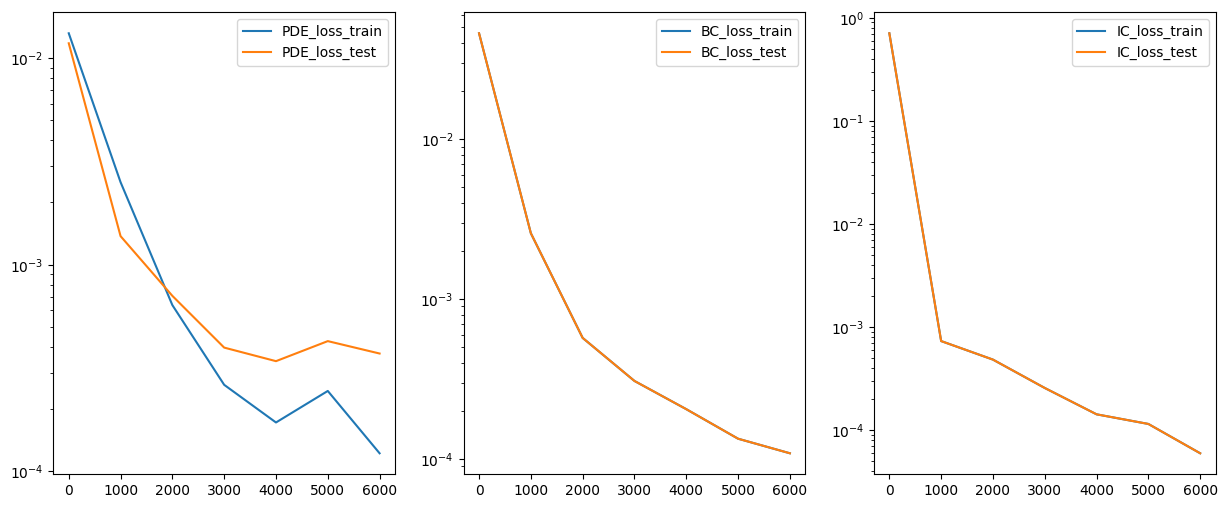

In [45]:
if opti_hyperparametre or not(model_opti):
    if opti_hyperparametre: 
        array_losstrain = np.array(losshistory.loss_train)
        array_losstest = np.array(losshistory.loss_test)
    else:
        array_losstrain = np.array(best_losshistory.loss_train)
        array_losstest = np.array(best_losshistory.loss_test)
        
    nb_step = np.array(best_losshistory.steps)

    PDE_loss_train = array_losstrain[:, 0]
    BC_loss_train = array_losstrain[:, 1]
    IC_loss_train = array_losstrain[:, 2]

    PDE_loss_test = array_losstest[:, 0]
    BC_loss_test = array_losstest[:, 1]
    IC_loss_test = array_losstest[:, 2]

    fig, axs = plt.subplots(1, 3, figsize= (15, 6))
    for i in range(3):
        axs[i].set_yscale('log')


    axs[0].plot(nb_step, PDE_loss_train, label="PDE_loss_train")
    axs[1].plot(nb_step, BC_loss_train, label="BC_loss_train")
    axs[2].plot(nb_step, IC_loss_train, label="IC_loss_train")

    axs[0].plot(nb_step, PDE_loss_test, label="PDE_loss_test")
    axs[1].plot(nb_step, BC_loss_test, label="BC_loss_test")
    axs[2].plot(nb_step, IC_loss_test, label="IC_loss_test")

    for i in range(3):
        axs[i].legend()

    plt.legend()
    plt.show()


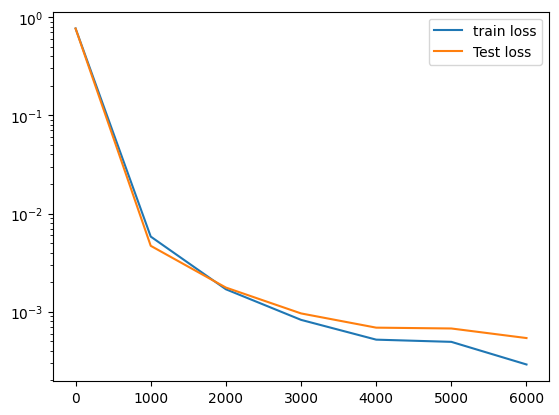

In [46]:
if opti_hyperparametre or not(model_opti):
    Train_loss = PDE_loss_train + BC_loss_train + IC_loss_train
    Test_loss = PDE_loss_test + BC_loss_test + IC_loss_test

    plt.plot(nb_step, Train_loss, label="train loss")
    plt.plot(nb_step, Test_loss, label="Test loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

Test Losses

**Some difference and solution plots**

(100, 1)


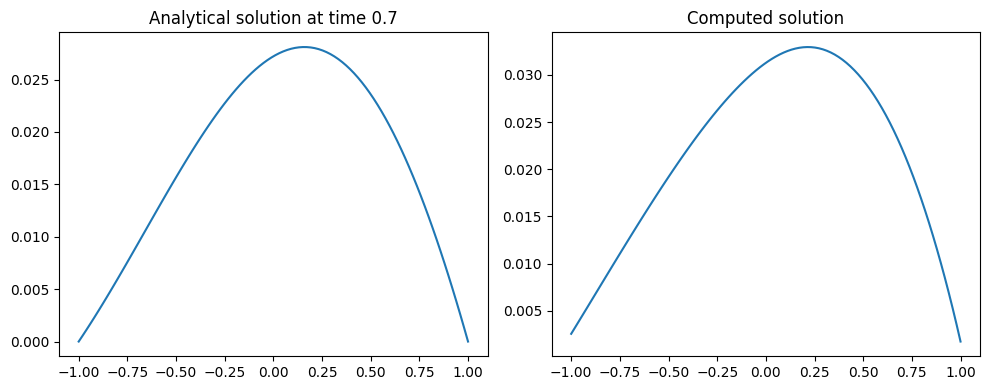

In [47]:
# Define the time t_1 at which you want to display the function
t_1 = 0.7

# Define the spatial domain where you want to evaluate the function
x = np.linspace(-1, 1, 100)

# Evaluate the function u(x, t) at the specified time t_1 and spatial domain x
u_x_t1 = model_print.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)]))) #Makes a vertical 2d vector

print(np.shape(u_x_t1))
#analytical solution
a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N= 33)



# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot something on the first subplot
axs[0].plot(x, a_x_t1)
axs[0].set_title('Analytical solution at time {}'.format(t_1))

# Plot something on the second subplot
axs[1].plot(x, u_x_t1)
axs[1].set_title('Computed solution')

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plots
plt.show()

In [48]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [49]:

Order = 5000
t = np.linspace(0, 1, 30)
x = np.linspace(-1, 1, 100)

# Initialize the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
u_x_t1 = model_print.predict(np.transpose(np.vstack([x, 0*np.ones_like(x)])))
a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)
diff = a_x_t1 - u_x_t1[:, 0]
print(np.shape(u_x_t1))
print(np.shape(a_x_t1))
print(np.shape(diff))


# Initialize the lines to be updated in the animation
line_analytical, = axs[0].plot([], [], label='Analytical solution')
line_computed, = axs[1].plot([], [], label='Computed solution')

axs[0].set_xlim([-1, 1])
axs[1].set_xlim([-1, 1])

axs[0].set_ylim([a_x_t1.min(), a_x_t1.max()])
axs[1].set_ylim([u_x_t1.min(), u_x_t1.max()])

# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    u_x_t1 = model_print.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)])))
    a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N=Order)
    
    line_analytical.set_data(x, a_x_t1)
    line_computed.set_data(x, u_x_t1)
    
    axs[0].set_title('Analytical solution at time {}'.format(t_1))
    axs[1].set_title('Computed solution at time {}'.format(t_1))
    
    return line_analytical, line_computed




# Create the animations

animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())




(100, 1)
(100,)
(100,)


In [50]:
Order = 5000
t = np.linspace(0, 1, 30)
x = np.linspace(-1, 1, 100)

# Initialize the figure and subplots
fig, axs = plt.subplots(1, 1)
u_x_t1 = model_print.predict(np.transpose(np.vstack([x, 0*np.ones_like(x)])))
a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)
diff = a_x_t1 - u_x_t1[:,0]

cste_max_list = [np.max(np.absolute(diff))]

# print(np.shape(diff))


# Initialize the lines to be updated in the animation
line_diff, = axs.plot([], [], label='Analytical-computed  solution')



# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    u_x_t1 = model_print.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)])))
    a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N=Order)
    diff = a_x_t1 - u_x_t1[:,0]
    cste_max_list.append(np.max(np.absolute(diff))) 

    line_diff.set_data(x, diff)
    axs.set_title('Analytical solution at time {}'.format(t_1))
    
    return line_diff,
print(cste_max_list)
C_max = max(cste_max_list)
axs.set_xlim([-1, 1])
# axs.set_ylim([-C_max, C_max])

# Create the animations
animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())




[0.043355666100978726]


**Error Checks**

In [51]:
from numpy import linalg

In [52]:
'''L2 difference computation'''
space_step = 100
time_step = 100

# geom = dde.geometry.Interval(-1, 1)
# timedomain = dde.geometry.TimeDomain(0, 1)
# geomtime = dde.geometry.GeometryXTime(geom, timedomain)

x = geomtime.uniform_points(space_step*time_step, boundary=True)
y_true = analytical_sol(x[:,0], x[:,1], N=500)
y_pred = model_print.predict(x)[:, 0] #Watch out: shape of model.predict is  (10082, 1).
print(np.shape(y_pred))
print(np.shape(y_true))


error= dde.metrics.l2_relative_error(y_true, y_pred) 
# print(y_pred)
print("\nDeepXDE-made relative error: ", error*100, "%")


#Hand-made verifications
error_hand_made = np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true) #default 2-norm
print("\nHand-made relative error ", error_hand_made*100, "%")

(10082,)
(10082,)

DeepXDE-made relative error:  3.2897554337978363 %

Hand-made relative error  3.2897554337978363 %
